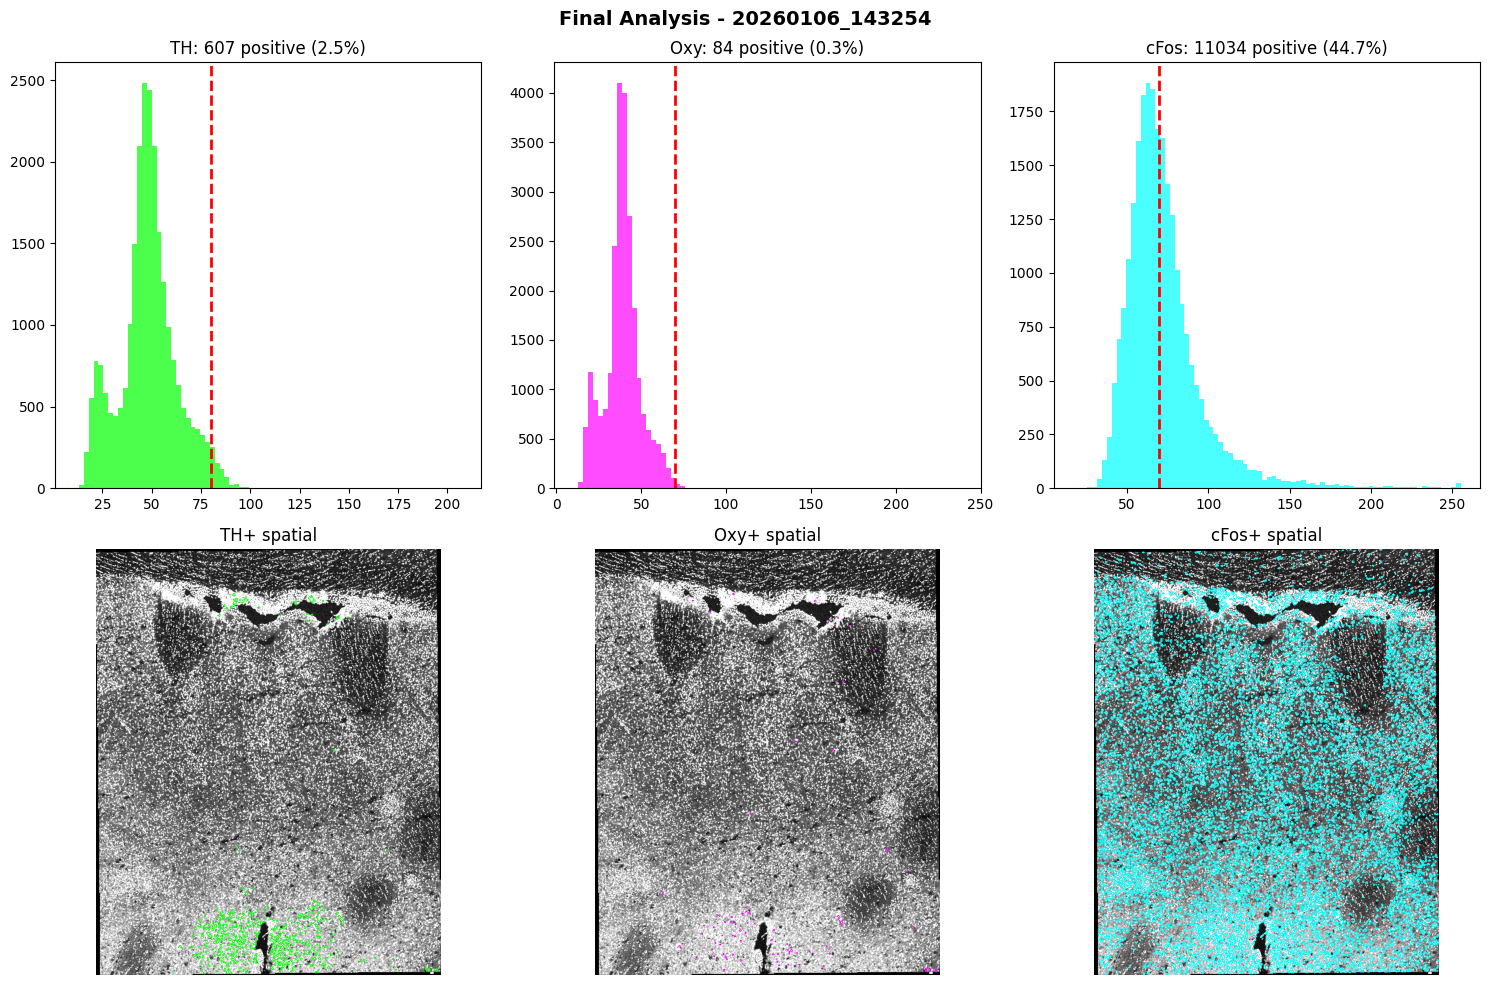

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from datetime import datetime

# Load data once
df = pd.read_csv('pvn_cell_analysis.csv')
masks = io.imread('/home/lq53/mir_repos/histology_for_minji/masks_cellpose.tif')
dapi_rgb = io.imread('PVN, MD, RE image61_R 91_Merged_ch00_SV.tif')
th_rgb = io.imread('PVN, MD, RE image61_R 91_Merged_ch01_SV.tif')
oxy_rgb = io.imread('PVN, MD, RE image61_R 91_Merged_ch02_SV.tif')
cfos_rgb = io.imread('PVN, MD, RE image61_R 91_Merged_ch03_SV.tif')

dapi = dapi_rgb[..., 2]
th = th_rgb[..., 1]
oxy = oxy_rgb[..., 0]
cfos = cfos_rgb[..., 0]

scale = 4
dapi_small = dapi[::scale, ::scale]
masks_small = masks[::scale, ::scale]

COLORS = {'TH': '#00FF00', 'Oxy': '#FF00FF', 'cFos': '#00FFFF'}

# Store current state
current_state = {}

def get_column(marker, use_max):
    """Get the appropriate column name based on mean/max toggle"""
    suffix = '_max' if use_max else '_mean'
    return f'{marker}{suffix}'

def show_threshold_examples(marker, thresh, n_examples, use_max):
    col = get_column(marker, use_max)
    img_dict = {'TH': th, 'Oxy': oxy, 'cFos': cfos}
    img = img_dict[marker]
    color = COLORS[marker]
    
    n_per_row = n_examples // 2
    
    above = df[df[col] > thresh].nsmallest(n_per_row, col)
    below = df[df[col] <= thresh].nlargest(n_per_row, col)
    
    fig, axes = plt.subplots(2, n_per_row, figsize=(2.5 * n_per_row, 5))
    metric_label = "max" if use_max else "mean"
    fig.suptitle(f'{marker} threshold = {thresh:.0f} ({metric_label})', fontsize=14)
    
    pad = 50
    
    for i, (_, cell) in enumerate(above.iterrows()):
        ax = axes[0, i]
        cy, cx = int(cell['y']), int(cell['x'])
        cell_id = int(cell['cell_id'])
        
        y1, y2 = max(0, cy - pad), min(img.shape[0], cy + pad)
        x1, x2 = max(0, cx - pad), min(img.shape[1], cx + pad)
        
        crop_img = img[y1:y2, x1:x2]
        crop_mask = masks[y1:y2, x1:x2]
        
        ax.imshow(crop_img, cmap='gray', vmin=0, vmax=150)
        cell_mask = (crop_mask == cell_id)
        if cell_mask.any():
            ax.contour(cell_mask, colors=[color], linewidths=2, levels=[0.5])
        
        ax.set_title(f"✓ {cell[col]:.0f}", color='green', fontsize=10, fontweight='bold')
        ax.axis('off')
    axes[0, 0].set_ylabel('POSITIVE', fontsize=12, color='green', fontweight='bold')
    
    for i, (_, cell) in enumerate(below.iterrows()):
        ax = axes[1, i]
        cy, cx = int(cell['y']), int(cell['x'])
        cell_id = int(cell['cell_id'])
        
        y1, y2 = max(0, cy - pad), min(img.shape[0], cy + pad)
        x1, x2 = max(0, cx - pad), min(img.shape[1], cx + pad)
        
        crop_img = img[y1:y2, x1:x2]
        crop_mask = masks[y1:y2, x1:x2]
        
        ax.imshow(crop_img, cmap='gray', vmin=0, vmax=150)
        cell_mask = (crop_mask == cell_id)
        if cell_mask.any():
            ax.contour(cell_mask, colors=['gray'], linewidths=1.5, linestyles='--', levels=[0.5])
        
        ax.set_title(f"✗ {cell[col]:.0f}", color='gray', fontsize=10)
        ax.axis('off')
    axes[1, 0].set_ylabel('NEGATIVE', fontsize=12, color='gray')
    
    plt.tight_layout()
    return fig

def update_display(th_thresh, oxy_thresh, cfos_thresh, show_marker, n_examples, 
                   th_use_max, oxy_use_max, cfos_use_max):
    clear_output(wait=True)
    
    # Store current state for saving
    current_state['th_thresh'] = th_thresh
    current_state['oxy_thresh'] = oxy_thresh
    current_state['cfos_thresh'] = cfos_thresh
    current_state['th_use_max'] = th_use_max
    current_state['oxy_use_max'] = oxy_use_max
    current_state['cfos_use_max'] = cfos_use_max
    
    # Get appropriate columns
    th_col = get_column('TH', th_use_max)
    oxy_col = get_column('Oxy', oxy_use_max)
    cfos_col = get_column('cFos', cfos_use_max)
    
    n_th = (df[th_col] > th_thresh).sum()
    n_oxy = (df[oxy_col] > oxy_thresh).sum()
    n_cfos = (df[cfos_col] > cfos_thresh).sum()
    
    th_cfos = ((df[th_col] > th_thresh) & (df[cfos_col] > cfos_thresh)).sum()
    oxy_cfos = ((df[oxy_col] > oxy_thresh) & (df[cfos_col] > cfos_thresh)).sum()
    
    fig = plt.figure(figsize=(16, 10))
    
    # Row 1: Histograms
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.hist(df[th_col], bins=80, alpha=0.7, color=COLORS['TH'], edgecolor='black')
    ax1.axvline(th_thresh, color='white', lw=3)
    ax1.axvline(th_thresh, color='black', lw=1.5, linestyle='--')
    metric = "max" if th_use_max else "mean"
    ax1.set_title(f'TH ({metric}): {n_th} cells ({n_th/len(df)*100:.1f}%)', fontweight='bold')
    ax1.set_xlim(0, 200 if th_use_max else 150)
    ax1.set_facecolor('#1a1a1a')
    
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.hist(df[oxy_col], bins=80, alpha=0.7, color=COLORS['Oxy'], edgecolor='black')
    ax2.axvline(oxy_thresh, color='white', lw=3)
    ax2.axvline(oxy_thresh, color='black', lw=1.5, linestyle='--')
    metric = "max" if oxy_use_max else "mean"
    ax2.set_title(f'Oxy ({metric}): {n_oxy} cells ({n_oxy/len(df)*100:.1f}%)', fontweight='bold')
    ax2.set_xlim(0, 200 if oxy_use_max else 150)
    ax2.set_facecolor('#1a1a1a')
    
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.hist(df[cfos_col], bins=80, alpha=0.7, color=COLORS['cFos'], edgecolor='black')
    ax3.axvline(cfos_thresh, color='white', lw=3)
    ax3.axvline(cfos_thresh, color='black', lw=1.5, linestyle='--')
    metric = "max" if cfos_use_max else "mean"
    ax3.set_title(f'cFos ({metric}): {n_cfos} cells ({n_cfos/len(df)*100:.1f}%)', fontweight='bold')
    ax3.set_xlim(0, 255 if cfos_use_max else 150)
    ax3.set_facecolor('#1a1a1a')
    
    # Row 2: Spatial maps
    pos_th_ids = set(df[df[th_col] > th_thresh]['cell_id'].astype(int))
    pos_oxy_ids = set(df[df[oxy_col] > oxy_thresh]['cell_id'].astype(int))
    pos_cfos_ids = set(df[df[cfos_col] > cfos_thresh]['cell_id'].astype(int))
    
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.imshow(dapi_small, cmap='gray', vmin=0, vmax=100)
    th_overlay = np.isin(masks_small, list(pos_th_ids))
    if th_overlay.any():
        ax4.contour(th_overlay, colors=[COLORS['TH']], linewidths=0.5, levels=[0.5])
    ax4.set_title(f'TH+ cells (n={n_th})', color=COLORS['TH'], fontweight='bold')
    ax4.axis('off')
    
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.imshow(dapi_small, cmap='gray', vmin=0, vmax=100)
    oxy_overlay = np.isin(masks_small, list(pos_oxy_ids))
    if oxy_overlay.any():
        ax5.contour(oxy_overlay, colors=[COLORS['Oxy']], linewidths=0.5, levels=[0.5])
    ax5.set_title(f'Oxy+ cells (n={n_oxy})', color=COLORS['Oxy'], fontweight='bold')
    ax5.axis('off')
    
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.imshow(dapi_small, cmap='gray', vmin=0, vmax=100)
    cfos_overlay = np.isin(masks_small, list(pos_cfos_ids))
    if cfos_overlay.any():
        ax6.contour(cfos_overlay, colors=[COLORS['cFos']], linewidths=0.5, levels=[0.5])
    ax6.set_title(f'cFos+ cells (n={n_cfos})', color=COLORS['cFos'], fontweight='bold')
    ax6.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show examples
    marker_thresh = {'TH': th_thresh, 'Oxy': oxy_thresh, 'cFos': cfos_thresh}
    marker_use_max = {'TH': th_use_max, 'Oxy': oxy_use_max, 'cFos': cfos_use_max}
    show_threshold_examples(show_marker, marker_thresh[show_marker], n_examples, marker_use_max[show_marker])
    plt.show()
    
    # Summary
    print("="*60)
    print("CURRENT SETTINGS:")
    print(f"  TH > {th_thresh} ({'max' if th_use_max else 'mean'}):    {n_th:5d} cells ({n_th/len(df)*100:5.1f}%)")
    print(f"  Oxy > {oxy_thresh} ({'max' if oxy_use_max else 'mean'}):   {n_oxy:5d} cells ({n_oxy/len(df)*100:5.1f}%)")
    print(f"  cFos > {cfos_thresh} ({'max' if cfos_use_max else 'mean'}):  {n_cfos:5d} cells ({n_cfos/len(df)*100:5.1f}%)")
    print(f"\nCOLOCALIZATION:")
    if n_th > 0:
        print(f"  TH+/cFos+:  {th_cfos:5d} ({th_cfos/n_th*100:5.1f}% of TH+)")
    if n_oxy > 0:
        print(f"  Oxy+/cFos+: {oxy_cfos:5d} ({oxy_cfos/n_oxy*100:5.1f}% of Oxy+)")
    print("="*60)

def save_results(b):
    """Save thresholds and export final results"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Get columns
    th_col = get_column('TH', current_state['th_use_max'])
    oxy_col = get_column('Oxy', current_state['oxy_use_max'])
    cfos_col = get_column('cFos', current_state['cfos_use_max'])
    
    # Apply thresholds
    df_export = df.copy()
    df_export['TH_positive'] = df_export[th_col] > current_state['th_thresh']
    df_export['Oxy_positive'] = df_export[oxy_col] > current_state['oxy_thresh']
    df_export['cFos_positive'] = df_export[cfos_col] > current_state['cfos_thresh']
    df_export['TH_cFos'] = df_export['TH_positive'] & df_export['cFos_positive']
    df_export['Oxy_cFos'] = df_export['Oxy_positive'] & df_export['cFos_positive']
    df_export['TH_Oxy'] = df_export['TH_positive'] & df_export['Oxy_positive']
    df_export['triple'] = df_export['TH_positive'] & df_export['Oxy_positive'] & df_export['cFos_positive']
    
    # Save thresholds JSON
    thresholds = {
        'timestamp': timestamp,
        'TH': {'threshold': current_state['th_thresh'], 'use_max': current_state['th_use_max']},
        'Oxy': {'threshold': current_state['oxy_thresh'], 'use_max': current_state['oxy_use_max']},
        'cFos': {'threshold': current_state['cfos_thresh'], 'use_max': current_state['cfos_use_max']},
        'results': {
            'total_cells': len(df),
            'TH_positive': int(df_export['TH_positive'].sum()),
            'Oxy_positive': int(df_export['Oxy_positive'].sum()),
            'cFos_positive': int(df_export['cFos_positive'].sum()),
            'TH_cFos': int(df_export['TH_cFos'].sum()),
            'Oxy_cFos': int(df_export['Oxy_cFos'].sum()),
        }
    }
    
    json_file = f'thresholds_{timestamp}.json'
    with open(json_file, 'w') as f:
        json.dump(thresholds, f, indent=2)
    
    # Save updated CSV
    csv_file = f'pvn_analysis_final_{timestamp}.csv'
    df_export.to_csv(csv_file, index=False)
    
    # Create summary figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    n_th = df_export['TH_positive'].sum()
    n_oxy = df_export['Oxy_positive'].sum()
    n_cfos = df_export['cFos_positive'].sum()
    
    # Histograms
    axes[0,0].hist(df_export[th_col], bins=80, alpha=0.7, color=COLORS['TH'])
    axes[0,0].axvline(current_state['th_thresh'], color='red', lw=2, ls='--')
    axes[0,0].set_title(f"TH: {n_th} positive ({n_th/len(df)*100:.1f}%)")
    
    axes[0,1].hist(df_export[oxy_col], bins=80, alpha=0.7, color=COLORS['Oxy'])
    axes[0,1].axvline(current_state['oxy_thresh'], color='red', lw=2, ls='--')
    axes[0,1].set_title(f"Oxy: {n_oxy} positive ({n_oxy/len(df)*100:.1f}%)")
    
    axes[0,2].hist(df_export[cfos_col], bins=80, alpha=0.7, color=COLORS['cFos'])
    axes[0,2].axvline(current_state['cfos_thresh'], color='red', lw=2, ls='--')
    axes[0,2].set_title(f"cFos: {n_cfos} positive ({n_cfos/len(df)*100:.1f}%)")
    
    # Spatial
    pos_th_ids = set(df_export[df_export['TH_positive']]['cell_id'].astype(int))
    pos_oxy_ids = set(df_export[df_export['Oxy_positive']]['cell_id'].astype(int))
    pos_cfos_ids = set(df_export[df_export['cFos_positive']]['cell_id'].astype(int))
    
    axes[1,0].imshow(dapi_small, cmap='gray', vmin=0, vmax=100)
    th_ov = np.isin(masks_small, list(pos_th_ids))
    if th_ov.any():
        axes[1,0].contour(th_ov, colors=[COLORS['TH']], linewidths=0.5)
    axes[1,0].set_title('TH+ spatial'); axes[1,0].axis('off')
    
    axes[1,1].imshow(dapi_small, cmap='gray', vmin=0, vmax=100)
    oxy_ov = np.isin(masks_small, list(pos_oxy_ids))
    if oxy_ov.any():
        axes[1,1].contour(oxy_ov, colors=[COLORS['Oxy']], linewidths=0.5)
    axes[1,1].set_title('Oxy+ spatial'); axes[1,1].axis('off')
    
    axes[1,2].imshow(dapi_small, cmap='gray', vmin=0, vmax=100)
    cfos_ov = np.isin(masks_small, list(pos_cfos_ids))
    if cfos_ov.any():
        axes[1,2].contour(cfos_ov, colors=[COLORS['cFos']], linewidths=0.5)
    axes[1,2].set_title('cFos+ spatial'); axes[1,2].axis('off')
    
    plt.suptitle(f'Final Analysis - {timestamp}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    fig_file = f'pvn_analysis_final_{timestamp}.png'
    plt.savefig(fig_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("✓ SAVED FILES:")
    print(f"  Thresholds: {json_file}")
    print(f"  Data:       {csv_file}")
    print(f"  Figure:     {fig_file}")
    print("="*60)

# Sliders
th_slider = widgets.IntSlider(value=80, min=30, max=200, step=5, description='TH:')
oxy_slider = widgets.IntSlider(value=70, min=30, max=200, step=5, description='Oxy:')
cfos_slider = widgets.IntSlider(value=70, min=30, max=200, step=5, description='cFos:')

# Mean/Max toggles
th_max_toggle = widgets.Checkbox(value=False, description='use max')
oxy_max_toggle = widgets.Checkbox(value=False, description='use max')
cfos_max_toggle = widgets.Checkbox(value=True, description='use max')  # Default max for cFos

marker_dropdown = widgets.Dropdown(options=['TH', 'Oxy', 'cFos'], value='cFos', description='Examples:')
n_examples_slider = widgets.IntSlider(value=10, min=4, max=20, step=2, description='# shown:')

save_button = widgets.Button(description='💾 Save Results', button_style='success')
save_button.on_click(save_results)

out = widgets.interactive_output(update_display, {
    'th_thresh': th_slider, 'oxy_thresh': oxy_slider, 'cfos_thresh': cfos_slider,
    'show_marker': marker_dropdown, 'n_examples': n_examples_slider,
    'th_use_max': th_max_toggle, 'oxy_use_max': oxy_max_toggle, 'cfos_use_max': cfos_max_toggle
})

# Layout
controls = widgets.VBox([
    widgets.HTML("<h3>🔬 Threshold Tuning</h3>"),
    widgets.HBox([th_slider, th_max_toggle]),
    widgets.HBox([oxy_slider, oxy_max_toggle]),
    widgets.HBox([cfos_slider, cfos_max_toggle]),
    widgets.HTML("<hr>"),
    marker_dropdown, n_examples_slider,
    widgets.HTML("<hr>"),
    save_button
])

display(widgets.HBox([controls, out]))